# Training a ResNet binary classifier to detect whale upcalls

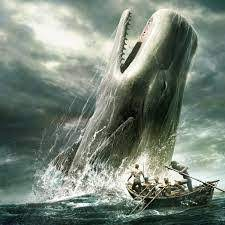

This notebook describes the steps to train a ResNet classifier using data provided by the Meridian project and their Python Library: **Ketos** <br>

The main objective is to obtain a model pre-trained on whales and assess if such model is useful to identify Dolphin audio. <br>

* A GPU type Runtime is recommended for the training. <br> 

Ketos can be installed via pip:

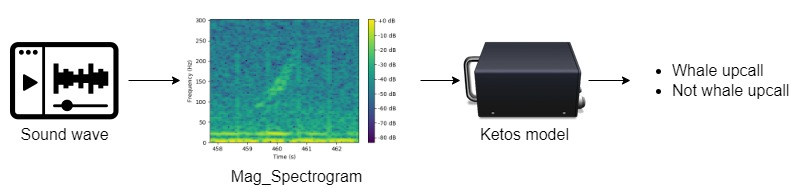

In [ ]:
!pip install ketos

##Importing libraries and data

In [ ]:
import pandas as pd
from ketos.data_handling import selection_table as sl
import ketos.data_handling.database_interface as dbi
from ketos.data_handling.parsing import load_audio_representation
from ketos.audio.spectrogram import MagSpectrogram
from ketos.data_handling.parsing import load_audio_representation

from ketos.neural_networks.resnet import ResNetInterface
from google.colab import files

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Identifying GPU device and listing:


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
#getting the data
!wget https://gitlab.meridian.cs.dal.ca/public_projects/ketos_tutorials/-/raw/master/tutorials/create_database/database_creation_tutorial.zip

--2021-11-25 14:46:30--  https://gitlab.meridian.cs.dal.ca/public_projects/ketos_tutorials/-/raw/master/tutorials/create_database/database_creation_tutorial.zip
Resolving gitlab.meridian.cs.dal.ca (gitlab.meridian.cs.dal.ca)... 206.12.88.81
Connecting to gitlab.meridian.cs.dal.ca (gitlab.meridian.cs.dal.ca)|206.12.88.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169628696 (162M) [application/zip]
Saving to: ‘database_creation_tutorial.zip’

database_creation_t 100%[===================>] 161.77M  45.7MB/s    in 4.0s    

2021-11-25 14:46:35 (40.2 MB/s) - ‘database_creation_tutorial.zip’ saved [169628696/169628696]



In [ ]:
!unzip -q database_creation_tutorial.zip

##Spectrogram configuration
Ketos uses Mag spectrograms. While Mel Spectrograms are better for working with souds that are suited for human hearing perception, Mag Spectrograms are more used for respresenting the sounds that whales produce.

The developers of Ketos (Meridian) provide a json file for the spectrogram configuration to be used, in their website. Unfortunatedly this spec file doesn't work with their framework. After inspection, I have discovered that it is missing the "duration" attribute: only 7 attributes instead of 8. Therefore I'll replace it with the correct one that I made ;) 

In [ ]:
!cat spec_config.json #the provided spec file

{
    "spectrogram": {
	"rate": "1000 Hz", 
        "window": "0.256 s",
        "step": "0.032 s",
        "freq_min": "0 Hz",
        "freq_max": "500 Hz",
        "window_func": "hamming",
        "type": "MagSpectrogram"
    }
}



In [ ]:
good_spec=files.upload()

In [ ]:
!cat spec_config2.json #the spec file including the "duration"

##Loading annotations
The annotation files are kindly provided by the Meridian in their [git repository](https://gitlab.meridian.cs.dal.ca/workshops/victoria_nov2019/-/tree/master)

In [ ]:
#Loading annotations
annot_train = pd.read_csv("annotations_train.csv")
annot_test = pd.read_csv("annotations_test.csv")

##Data handling

In [ ]:
#checking if annotations are confom to ketos standard
sl.is_standardized(annot_train) #f*ck it it is not the ketos format T_T

 Your table is not in the Ketos format.

            It should have two levels of indices: filename and annot_id.
            It should also contain at least the 'label' column.
            If your annotations have time information, these should appear in the 'start' and 'end' columns

            extra columns are allowed.

            Here is a minimum example:

                                 label
            filename  annot_id                    
            file1.wav 0          2
                      1          1
                      2          2
            file2.wav 0          2
                      1          2
                      2          1


            And here is a table with time information and a few extra columns ('min_freq', 'max_freq' and 'file_time_stamp')

                                 start   end  label  min_freq  max_freq  file_time_stamp
            filename  annot_id                    
            file1.wav 0           7.0   8.1      2    180.6     2

False

In [ ]:
#standardizing the annotations
map_to_ketos_annot_std ={'sound_file': 'filename'} 
std_annot_train = sl.standardize(table=annot_train, signal_labels=["upcall"], mapper=map_to_ketos_annot_std, trim_table=True)
std_annot_test = sl.standardize(table=annot_test, signal_labels=["upcall"], mapper=map_to_ketos_annot_std, trim_table=True)

In [ ]:
sl.is_standardized(std_annot_train) #now it is ketos format!

True

In [ ]:
#creating segments of uniform lenght
positives_train = sl.select(annotations=std_annot_train, length=3.0)
positives_test = sl.select(annotations=std_annot_test, length=3.0, step=0.0, center=False)

**Data augmentation:**
After some research, I stumbled upon several two strategies to augment audio data. One is frequency shift: making the pitch slighly higher (by a semitone for example). Although useful for augementing data for song recognition or human voice, it is not very accurate to use in animalsounds (in my humble opinion). We will be using the frameshif as shown below:

In [ ]:
#adding overlaps & frameshifts
positives_train = sl.select(annotations=std_annot_train, length=3.0, step=0.5, min_overlap=0.5, center=False)

In [ ]:
#adding background from negative files (not useful when there is already background noise)
file_durations_train = sl.file_duration_table('data/train')
file_durations_test = sl.file_duration_table('data/test') 

In [ ]:
#generating the negatives
negatives_train=sl.create_rndm_backgr_selections(annotations=std_annot_train, files=file_durations_train, length=3.0, num=len(positives_train), trim_table=True)
negatives_train

start         end  label
filename                      sel_id                               
NOPP6_EST_20090328_000000.wav 0        60.582229   63.582229      0
                              1        62.228212   65.228212      0
                              2        72.649023   75.649023      0
                              3        95.331555   98.331555      0
                              4       108.398098  111.398098      0
...                                          ...         ...    ...
NOPP6_EST_20090329_031500.wav 32      774.321525  777.321525      0
                              33      774.747660  777.747660      0
                              34      788.653161  791.653161      0
                              35      805.008747  808.008747      0
                              36      837.973922  840.973922      0

[2762 rows x 3 columns]

In [ ]:
negatives_test=sl.create_rndm_backgr_selections(annotations=std_annot_train, files=file_durations_test, length=3.0, num=len(positives_test), trim_table=True)
negatives_test

start         end  label
filename                      sel_id                               
NOPP6_EST_20090329_084500.wav 0         9.169846   12.169846      0
                              1        37.385895   40.385895      0
                              2        42.326248   45.326248      0
                              3        64.692523   67.692523      0
                              4        68.525481   71.525481      0
...                                          ...         ...    ...
NOPP6_EST_20090329_130000.wav 27      794.390012  797.390012      0
                              28      803.289754  806.289754      0
                              29      817.571905  820.571905      0
                              30      819.385464  822.385464      0
                              31      822.312839  825.312839      0

[500 rows x 3 columns]

In [ ]:
selections_train = positives_train.append(negatives_train, sort=False)
selections_test = positives_test.append(negatives_test, sort=False)

In [ ]:
#veryfing spectrogram settings (if they are not OK, there won't be an error so we'll have to retrain again :( )
spec_cfg = load_audio_representation('spec_config2.json', name="spectrogram")

In [ ]:
spec_cfg

{'duration': 3.0,
 'freq_max': 500,
 'freq_min': 0,
 'rate': 1000,
 'step': 0.032,
 'type': 'MagSpectrogram',
 'window': 0.256,
 'window_func': 'hamming'}

##Creating the database




In [ ]:
#creating database
dbi.create_database(output_file='database.h5', data_dir='data/train',
                               dataset_name='train',selections=selections_train,
                               audio_repres=spec_cfg)

100%|██████████| 5524/5524 [01:01<00:00, 89.63it/s]

5524 items saved to database.h5


In [ ]:
dbi.create_database(output_file='database.h5', data_dir='data/test',
                               dataset_name='test',selections=selections_test,
                               audio_repres=spec_cfg)

100%|██████████| 1000/1000 [00:11<00:00, 89.98it/s]

1000 items saved to database.h5


In [ ]:
db = dbi.open_file("database.h5", 'r')

In [ ]:
db

File(filename=database.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/test (Group) ''
/test/data (Table(1000,), fletcher32, shuffle, zlib(1)) ''
  description := {
  "data": Float32Col(shape=(94, 129), dflt=0.0, pos=0),
  "filename": StringCol(itemsize=100, shape=(), dflt=b'', pos=1),
  "id": UInt32Col(shape=(), dflt=0, pos=2),
  "label": UInt8Col(shape=(), dflt=0, pos=3),
  "offset": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (5,)
/train (Group) ''
/train/data (Table(5524,), fletcher32, shuffle, zlib(1)) ''
  description := {
  "data": Float32Col(shape=(94, 129), dflt=0.0, pos=0),
  "filename": StringCol(itemsize=100, shape=(), dflt=b'', pos=1),
  "id": UInt32Col(shape=(), dflt=0, pos=2),
  "label": UInt8Col(shape=(), dflt=0, pos=3),
  "offset": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (5,)

In [ ]:
db.close()

Stragely enough, the only way to avoid a NodeError further down is to close this database and reopen it O_o

In [ ]:
import numpy as np
np.random.seed(1000)

import tensorflow as tf
tf.random.set_seed(2000)

import ketos.data_handling.database_interface as dbi
from ketos.neural_networks.resnet import ResNetInterface
from ketos.data_handling.data_feeding import BatchGenerator

In [ ]:
db = dbi.open_file("database.h5", 'r')

In [ ]:
#I don't have enough data to split into 3 batches: train, val & test. Therefore I'll be testing on val_data.
#This is also intentional to trigger my colleague Benoit >_<
train_data = dbi.open_table(db, "/train/data")
val_data = dbi.open_table(db, "/test/data")

In [ ]:
# Below is an example of a simple data transformation function
# (However, in this tutorial we will use the ResNetInterface.transform_batch function provided by Ketos)
def transform_batch(X, Y):
  x = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
  y = tf.one_hot(Y['label'], depth=2, axis=1).numpy()
  return x, y
train_generator = BatchGenerator(batch_size=128, data_table=train_data, 
                                  output_transform_func=ResNetInterface.transform_batch,
                                  shuffle=True, refresh_on_epoch_end=True)

In [ ]:
val_generator = BatchGenerator(batch_size=128, data_table=val_data,
                                 output_transform_func=ResNetInterface.transform_batch,
                                 shuffle=True, refresh_on_epoch_end=False)

In [ ]:
#retrieveing the packaged model
narw = files.upload()

Saving narw.kt to narw.kt


In [ ]:
recipe_file = files.upload()

Saving recipe.json to recipe.json


In [ ]:
import ketos.neural_networks.dev_utils.detection as det
from ketos.audio.spectrogram import MagSpectrogram
from ketos.audio.audio_loader import AudioFrameLoader
from ketos.neural_networks.resnet import ResNetInterface

In [ ]:
resnet = ResNetInterface.build_from_recipe_file("recipe.json")

In [ ]:
resnet.train_generator = train_generator
resnet.val_generator = val_generator

In [ ]:
resnet.checkpoint_dir = "checkpoints"

##Training
Unfortunately, the ketos framework doesn't provide a .fit() function with their model definition. Therefore the only way to monitor training history is to produce la log file to record the verbose. 

In [ ]:
resnet.train_loop(n_epochs=30, verbose=True)

#train_loop(n_epochs, verbose=True, validate=True, log_tensorboard=False, tensorboard_metrics_name='tensorboard_metrics', log_csv=False, csv_name='log.csv', checkpoint_freq=5, early_stopping=False)


Epoch: 1 
train_loss: 0.005782293621450663
train_CategoricalAccuracy: 0.998 train_Precision: 0.997 train_Recall: 0.998 
val_loss: 0.101096011698246
val_CategoricalAccuracy: 0.912 val_Precision: 0.901 val_Recall: 0.926 


Epoch: 2 
train_loss: 0.005510173738002777
train_CategoricalAccuracy: 0.998 train_Precision: 0.997 train_Recall: 0.998 
val_loss: 0.0993807315826416
val_CategoricalAccuracy: 0.914 val_Precision: 0.895 val_Recall: 0.938 


Epoch: 3 
train_loss: 0.005623872857540846
train_CategoricalAccuracy: 0.998 train_Precision: 0.997 train_Recall: 0.998 
val_loss: 0.09945327043533325
val_CategoricalAccuracy: 0.913 val_Precision: 0.875 val_Recall: 0.964 


Epoch: 4 
train_loss: 0.00536620058119297
train_CategoricalAccuracy: 0.998 train_Precision: 0.997 train_Recall: 0.998 
val_loss: 0.09771426022052765
val_CategoricalAccuracy: 0.912 val_Precision: 0.889 val_Recall: 0.942 


Epoch: 5 
train_loss: 0.005184962414205074
train_CategoricalAccuracy: 0.998 train_Precision: 0.997 train_Recall

In [ ]:
db.close()

In [ ]:
#saving the model
#Ketos uses a .kt format where they compress the weights and the json recipe altogether
resnet.save_model('Mobydick2.kt',audio_repr_file='spec_config2.json')